# Instructions

We were given two datasets originating from online hotel reservations: 
1. Dataset '**_2024_DS2_HW1_data_train.csv_**' contains the reservation attributes together with the target, which is a binary variable **_BOOKING_STATUS_**, and is intended for model training.
2. Dataset '**_2024_DS2_HW1_data_test.csv_**' contains the same attributes as the dataset above with the exception of the target and is to be used as underlying data for prediction and model performance evaluatioverview).
s canceled or not.

Data consists of 32,647 entries (train + test) with the following attributes:
- **_Booking_ID:_** unique identifier of each booking
- **_no_of_adults:_** number of adults
- **_no_of_children:_** number of children
- **_no_of_weekend_nights:_** number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **_no_of_week_nights:_** number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **_type_of_meal_plan:_** type of meal plan booked by the customer
- **_required_car_parking_space:_** does the customer require a car parking space? (0 - No, 1 - Yes)
- **_room_type_reserved:_** type of room reserved by the customer, ciphered by INN Hotels
- **_lead_time:_** number of days between the date of booking and the arrival date
- **_arrival_year:_** year of arrival date
- **_arrival_month:_** month of arrival date
- **_arrival_date:_** date of the month
- **_market_segment_type:_** market segment designation
- **_repeated_guest:_** is the customer a repeated guest? (0 - No, 1 - Yes)
- **_no_of_previous_cancellations:_** number of previous bookings that were canceled by the customer prior to the current booking
- **_no_of_previous_bookings_not_canceled:_** number of previous bookings not canceled by the customer prior to the current booking
- **_avg_price_per_room:_** average price per day of the reservation (in euros)
- **_no_of_special_requests:_** total number of special requests made by the customer
- **_booking_status:_** flag indicating if the booking was canceled or not.


Our task is to predict if the customer will cancel a reservation or not using **xgboost.XGBClassifier** method..
.


The evaluation metric was AUC, and predictions on the test dataset were evaluated in [Kaggle](https://www.kaggle.com/competitions/data-science-2-2024-hw1/overview)

# Import packages

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from pathlib import Path

In [2]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200


# Load Data


## Loading training data
The following script loads data from the designated dataset.


In [3]:
# Load data - set index column, decimal point, separator
data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-23 08:43:38


In [4]:
data.head()
#´Quick check, if the dataset was loaded properly

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [5]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


## Loading data for prediction

In [6]:
# Load test data - set index column, decimal point, separator
test_data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_test.csv")
test_data = pd.read_csv(test_data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print data info
print(f'Number of rows:   {test_data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {test_data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {test_data.shape[1]:,}'.replace(',', ' '))

Number of rows:   3 593
Number of unique indexes:   3 593
Number of columns:   17


# Metadata Definitions

In the following section, we prepare our data for XGBoost. Firstly, we explore the distribution of the target variable and identify the number of missing values. Next, we categorize potential predictors into two groups based on their type: categorical and numerical.

In [7]:
# check values in column booking_status
data.booking_status.value_counts(dropna=False)
#352 NA values

booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [8]:
#We prepated labeling for eassier handeling 

#name of the target column
col_target = "booking_status"
#name of the month column
col_month = "arrival_month"

In [9]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan      object
room_type_reserved     object
market_segment_type    object
dtype: object


Since XGBoost is unable to handle categorical predictors directly, one of our tasks will be to encode them correctly. Specifically, we need to encode the following variables: **_type_of_meal_plan_**, **_room_type_reserved_**, and **_market_segment_type_**.

# Data exploration

In the following code snippets, we utilized some basic exploration tools to gain a better understanding of the variables' nature.

In [10]:
#Basic data desciption
description = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(description)
pd.options.display.max_rows = 200

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
no_of_adults,28231.0,NaN,NaN,NaN,1.845312,0.51686,0.0,2.0,2.0,2.0,4.0
no_of_children,5043.0,NaN,NaN,NaN,0.10351,0.407673,0.0,0.0,0.0,0.0,9.0
no_of_weekend_nights,7729.0,NaN,NaN,NaN,0.807737,0.873931,0.0,0.0,1.0,2.0,7.0
no_of_week_nights,24287.0,NaN,NaN,NaN,2.204966,1.411324,0.0,1.0,2.0,3.0,17.0
type_of_meal_plan,16544,4,Meal Plan 1,12767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_car_parking_space,17863.0,NaN,NaN,NaN,0.033645,0.180319,0.0,0.0,0.0,0.0,1.0
room_type_reserved,11360,7,Room_Type 1,8812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_time,6935.0,NaN,NaN,NaN,86.213266,85.926525,0.0,18.0,59.0,127.0,443.0
arrival_year,29654.0,NaN,NaN,NaN,2017.820092,0.384118,2017.0,2018.0,2018.0,2018.0,2018.0
arrival_month,31740.0,NaN,NaN,NaN,7.419817,3.062828,1.0,5.0,8.0,10.0,12.0


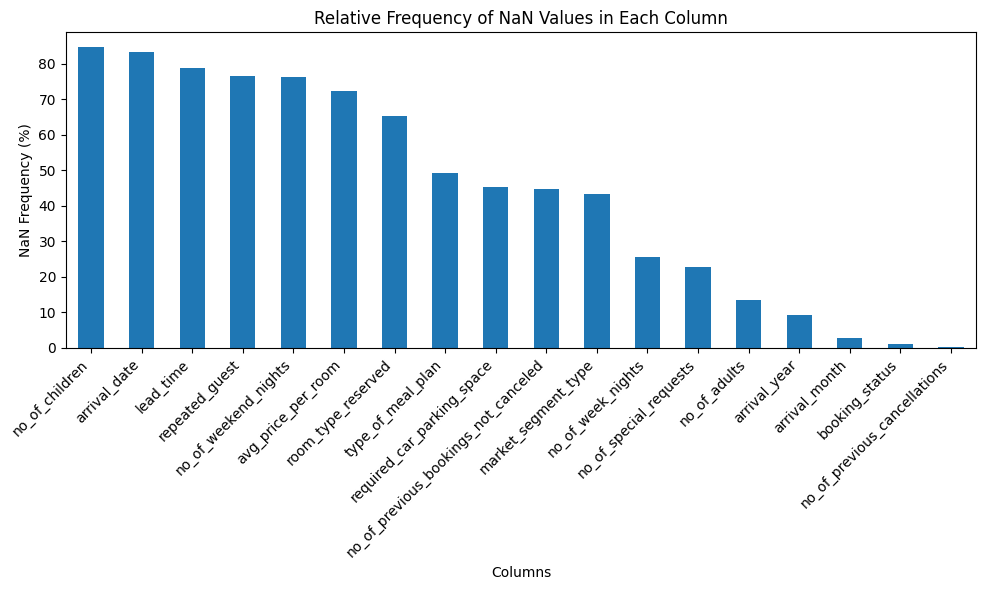

In [11]:
#Plots relative NA values present in each predictorb
def plot_nan_counts(data):
    # Count NaN values for each column
    nan_counts = data.isna().sum()
    
    # Calculate relative frequency of NaN values
    total_rows = len(data)
    relative_nan_counts = nan_counts / total_rows * 100  # Convert to percentage
    
    # Sort the results
    relative_nan_counts_sorted = relative_nan_counts.sort_values(ascending=False)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    relative_nan_counts_sorted.plot(kind='bar')
    plt.title('Relative Frequency of NaN Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('NaN Frequency (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your DataFrame
# Replace 'data' with the name of your DataFrame if it's different
plot_nan_counts(data)

We can observe that some predictors have a high number of missing values, which can provide valuable insights into their importance and significance in modeling.

# Data Split

In this part, we will split the dataset int otwe subsets: train, valid, and visualize them at the beginning of the model building, we also used third subset of test to compare different models, however for the final training such subset is not necessaryB). Notably, we employed stratification to achieve the most evenly spread sampl, however we only stratified the response ('booking_status') as in the predictors, the missing values cause issues, which can be delt with, however when employed (specificaly for the month of arrival, the final model did not improves. Furthermore, for XGBoost prediction to work properly, we needed to handle any missing values in the target variable. From the previous section, we learned that there are 352 missing values, which is about.1% of the sample. Given this fact, we simply ignored them.

In [12]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.6])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

In [13]:
data['sample'] = 'default'
target_mask = (data[col_target] >= 0) & (data[col_target] <= 1) #Restricting to reasonable values

data_train, data_valid = train_test_split(data[target_mask], test_size=0.05, random_state = 12, stratify = (data[target_mask][[col_target]])) #train and valid split using stratification wrt to #???
data.loc[data_train.index, 'sample'] = 'train'
data.loc[data_valid.index, 'sample'] = 'valid'
#data.loc[data_test.index, 'sample'] = 'test'

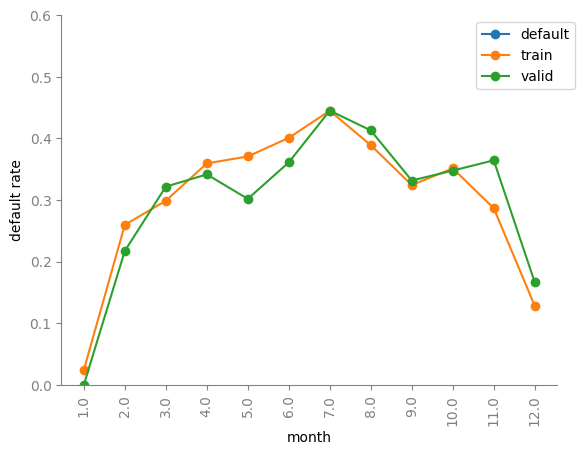

In [14]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')
#Visualization


Once again, in order to utilize missing values as additional information, we created a 13th month.

## Define Sample Masks

In [15]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
#test_mask = (data['sample'] == 'test') 

## Additional visualization

In order to gain more insights, we plotted the data in various ways. Additionally, we assessed the quality of the given data, searching for any potential outliers and considering possible transformations. Overall, all predictors appeared to be in good condition, with no nonsensical values or incorrect data types present.

In [16]:
#Almost self explanatory: Plots the mean of booking status wrt to each value present in the predictor
def plot_smoothed_means(data, col_target, col_month):
    # Group the data by col_month and calculate the mean of col_target for each group
    grouped_data = data.groupby(col_month)[col_target].mean().reset_index()
    
    # Smooth the data using rolling mean to create a smoother plot
    smoothed_means = grouped_data[col_target].rolling(window=3, min_periods=1).mean()
    
    # Plot the smoothed means
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=grouped_data[col_month], y=smoothed_means)
    plt.xlabel(col_month)
    plt.ylabel("Mean " + col_target)
    plt.title("Smoothed Mean " + col_target + " by " + col_month)
    plt.grid(True)
    plt.show()


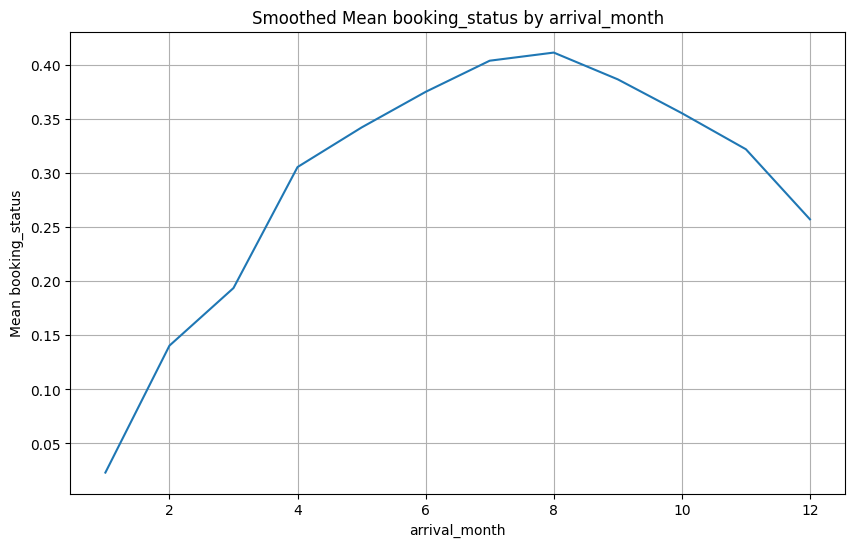

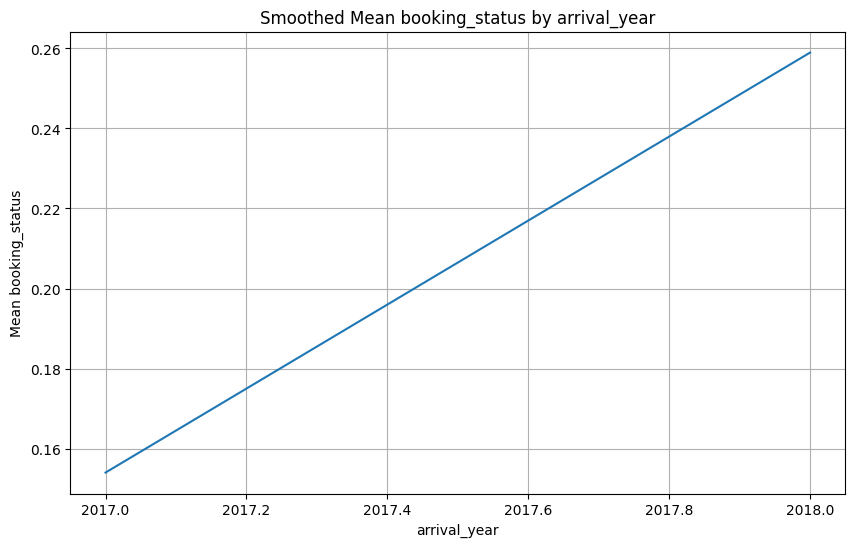

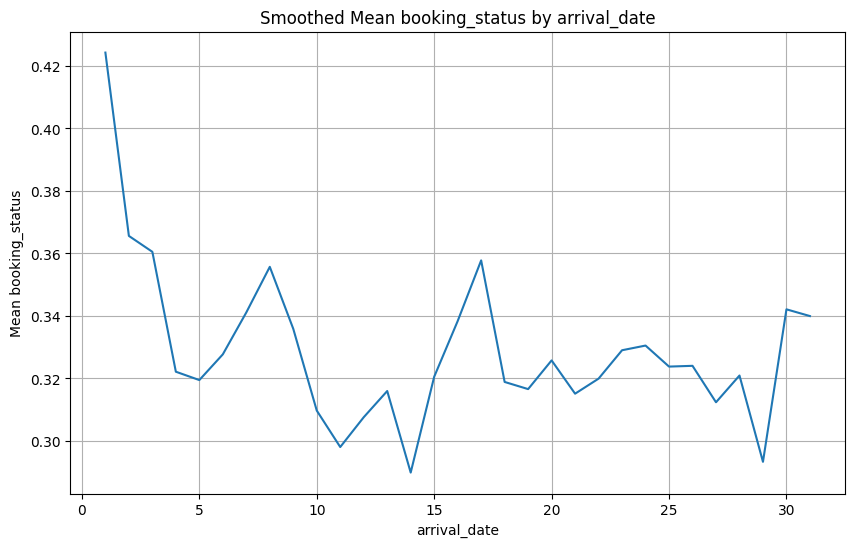

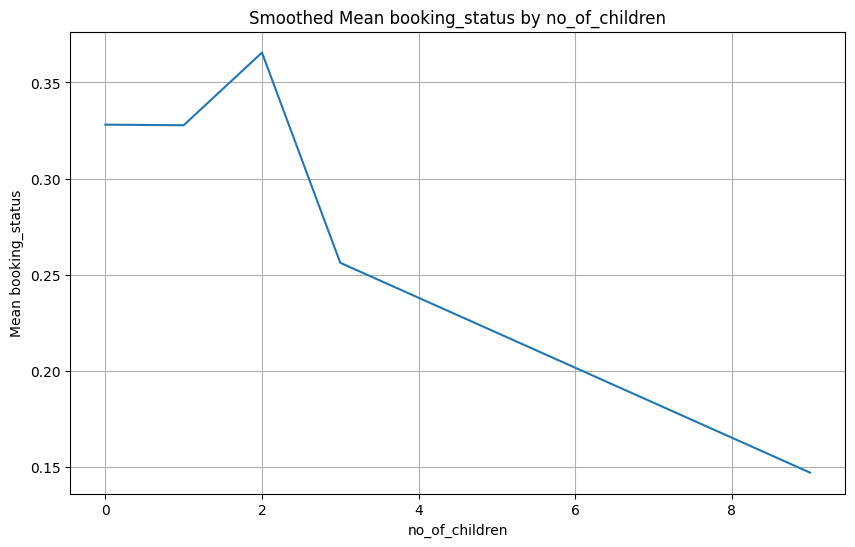

In [17]:
plot_smoothed_means(data, col_target, col_month)
plot_smoothed_means(data, col_target, 'arrival_year')
plot_smoothed_means(data, col_target, 'arrival_date')
plot_smoothed_means(data, col_target, 'no_of_children')


In [18]:
#Plots all predictors, namely histograms and the percentage of NA values in each predictor wrt to the sample
def plot_columns(columns, df):
    for col in columns:
        print('-' * 50)
        print('{}'.format(col.upper()))
        print('-' * 50)
        print('')
        k = int(df[col].nunique())
        
        
        if k < 2:
            print(f'{col} - only constant with value {df[col].unique()}')
        elif (k < 15) or (df[col].dtype == 'O'):
            info = '{:.2f}% is missing'.format(np.mean(df[col].isna()) * 100)
            print(info)
            
            ax = (df[col].value_counts(dropna=False).iloc[0:15] / df[col].shape[0]).plot.bar()
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            for p in ax.patches:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                _ = ax.annotate('{:.2f}%'.format(height * 100), (x + width/2, y + height + 0.02), ha='center')
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)


            plt.show()
            
        else:
            info = '{:.2f}% above 0'.format(np.mean(np.where(df[col] > 0, 1, 0)) * 100)
            print(info)

            info = '{:.2f}% is missing'.format(np.mean(df[col].isna()) * 100)
            print(info)
            
            ax = df[col].hist(log=True)
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            plt.show()

            ax = df[col].hist(log=False)
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            plt.show()

                

    print('\n')

--------------------------------------------------
NO_OF_ADULTS
--------------------------------------------------

13.53% is missing


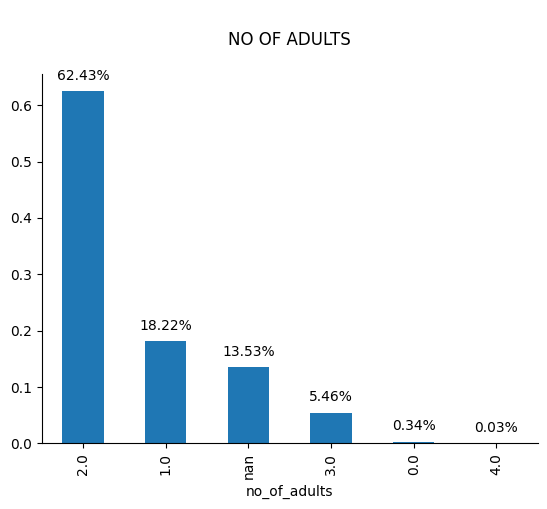

--------------------------------------------------
NO_OF_CHILDREN
--------------------------------------------------

84.55% is missing


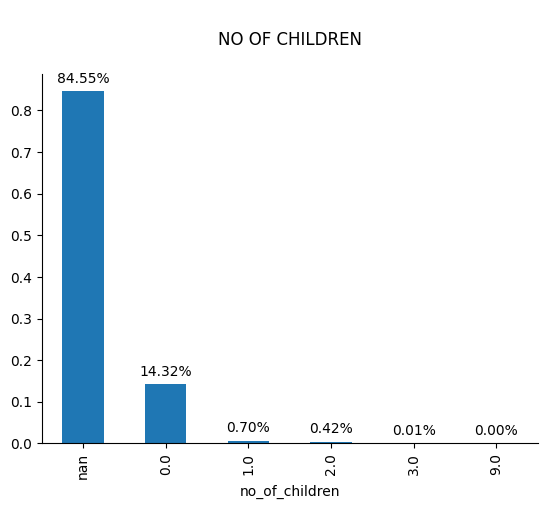

--------------------------------------------------
NO_OF_WEEKEND_NIGHTS
--------------------------------------------------

76.33% is missing


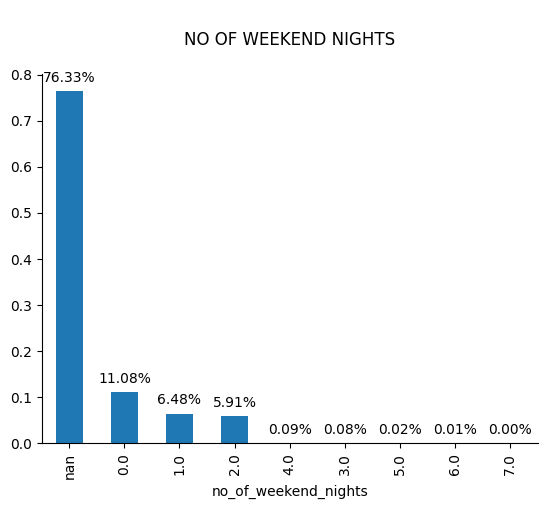

--------------------------------------------------
NO_OF_WEEK_NIGHTS
--------------------------------------------------

69.55% above 0
25.61% is missing


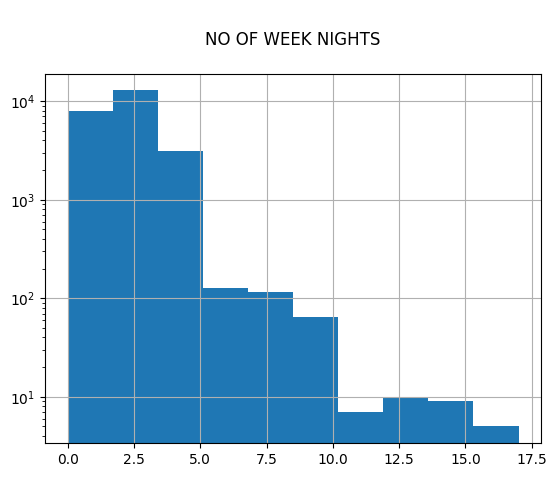

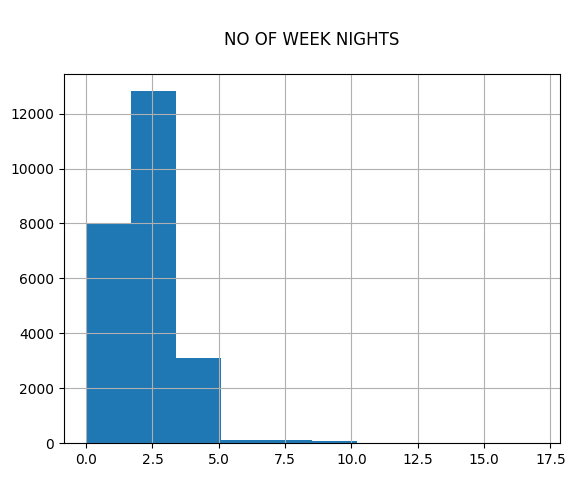

--------------------------------------------------
TYPE_OF_MEAL_PLAN
--------------------------------------------------

49.32% is missing


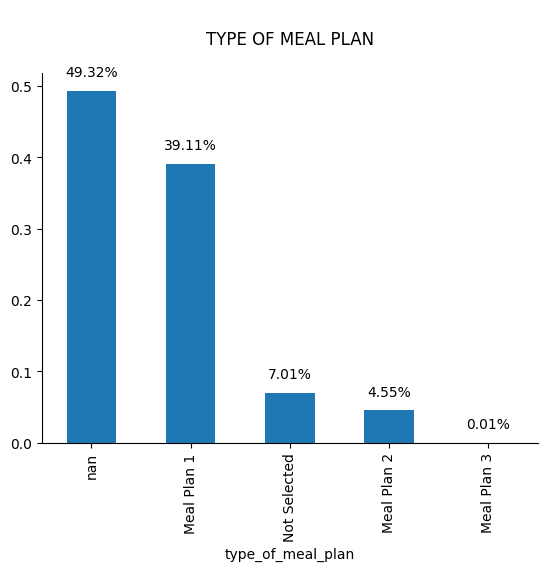

--------------------------------------------------
REQUIRED_CAR_PARKING_SPACE
--------------------------------------------------

45.28% is missing


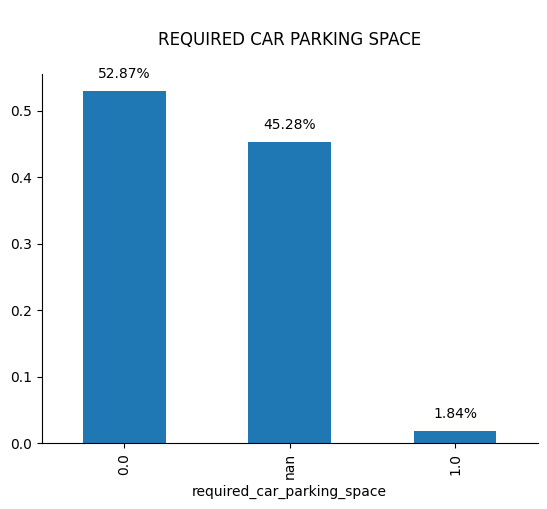

--------------------------------------------------
ROOM_TYPE_RESERVED
--------------------------------------------------

65.20% is missing


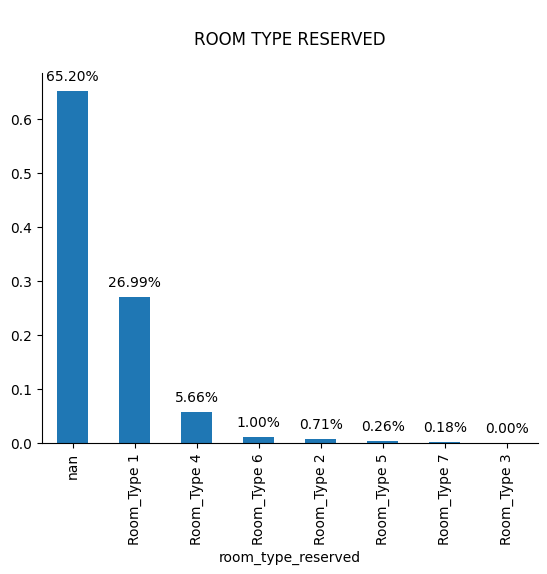

--------------------------------------------------
LEAD_TIME
--------------------------------------------------

20.52% above 0
78.76% is missing


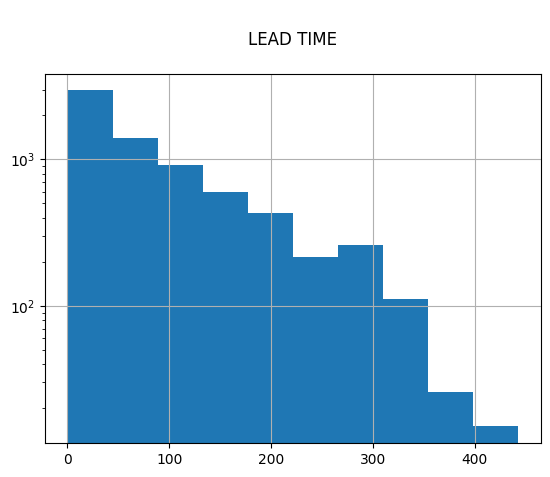

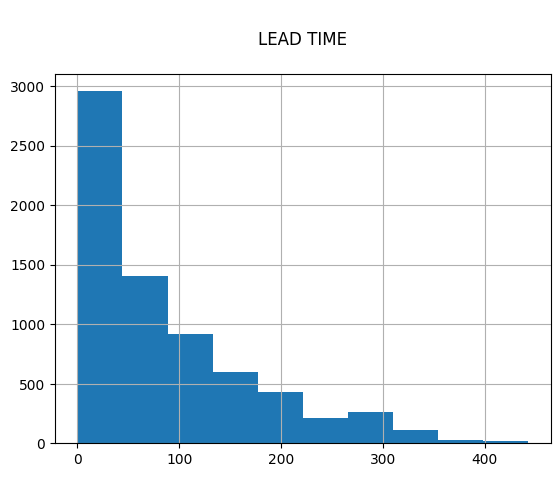

--------------------------------------------------
ARRIVAL_YEAR
--------------------------------------------------

9.17% is missing


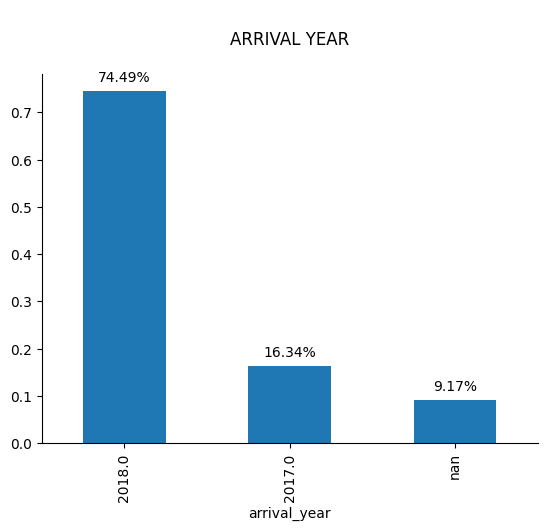

--------------------------------------------------
ARRIVAL_MONTH
--------------------------------------------------

2.78% is missing


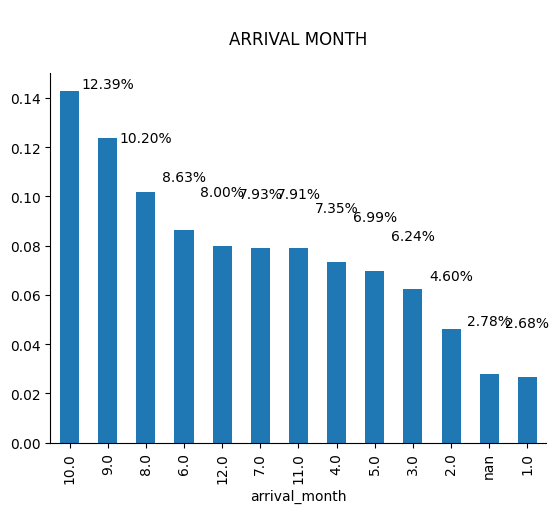

--------------------------------------------------
ARRIVAL_DATE
--------------------------------------------------

16.72% above 0
83.28% is missing


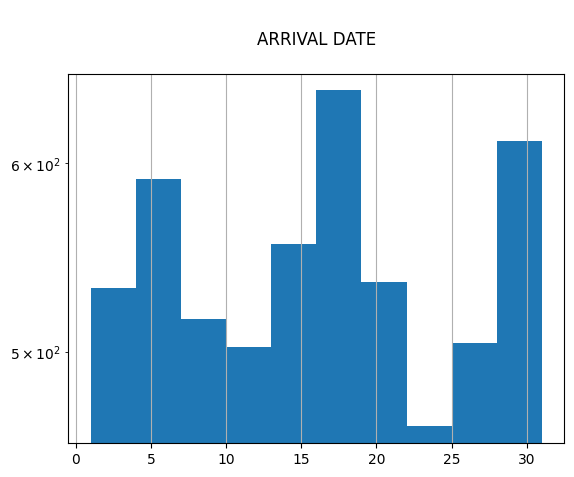

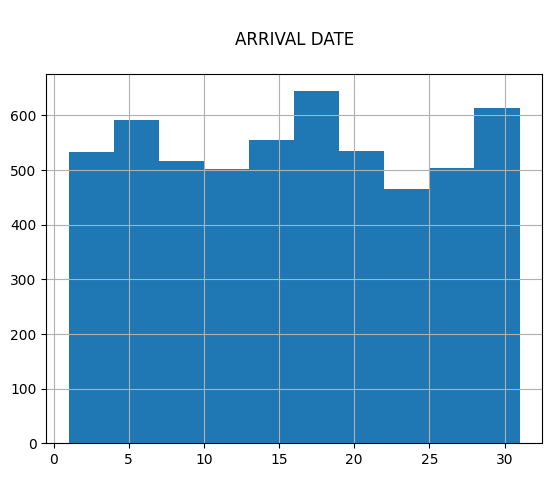

--------------------------------------------------
MARKET_SEGMENT_TYPE
--------------------------------------------------

43.25% is missing


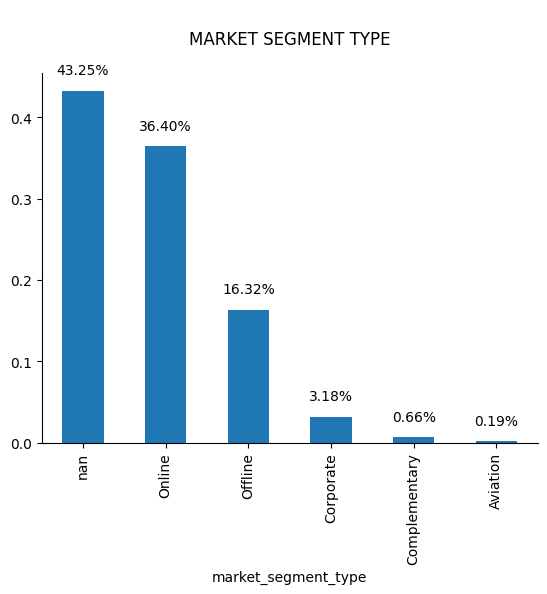

--------------------------------------------------
REPEATED_GUEST
--------------------------------------------------

76.51% is missing


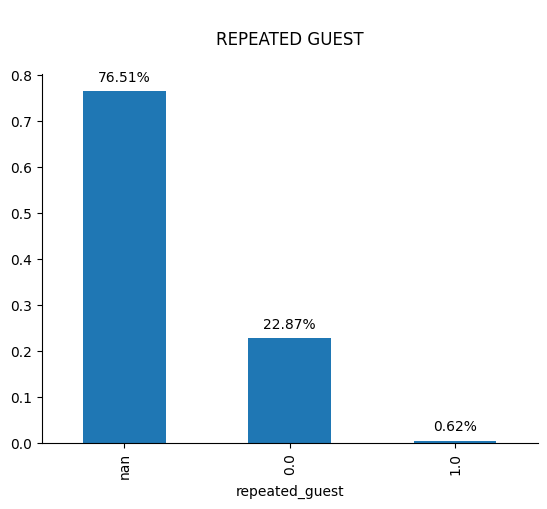

--------------------------------------------------
NO_OF_PREVIOUS_CANCELLATIONS
--------------------------------------------------

0.21% is missing


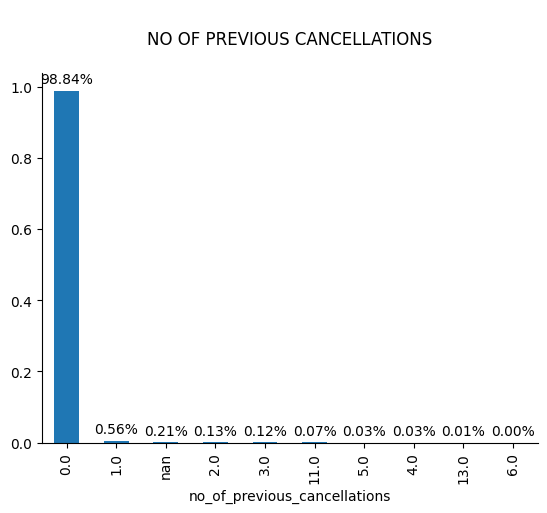

--------------------------------------------------
NO_OF_PREVIOUS_BOOKINGS_NOT_CANCELED
--------------------------------------------------

1.29% above 0
44.79% is missing


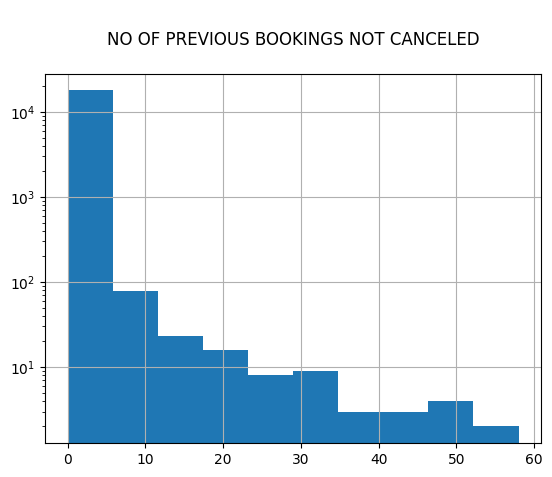

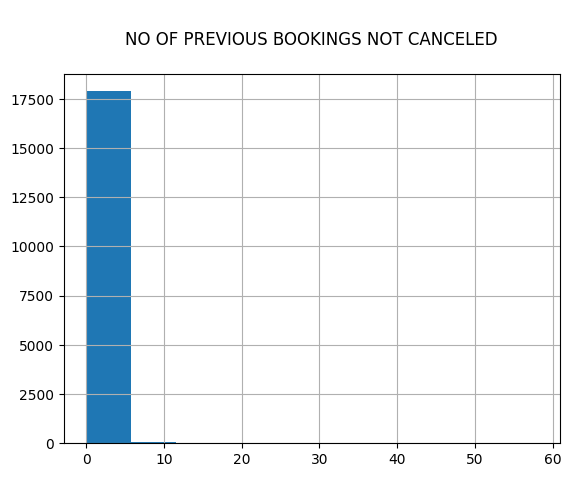

--------------------------------------------------
AVG_PRICE_PER_ROOM
--------------------------------------------------

27.33% above 0
72.25% is missing


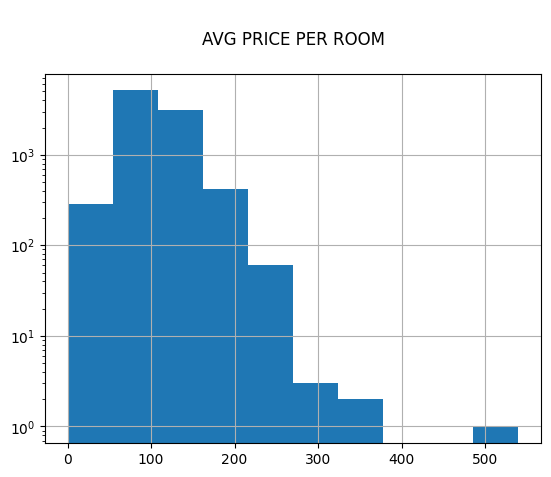

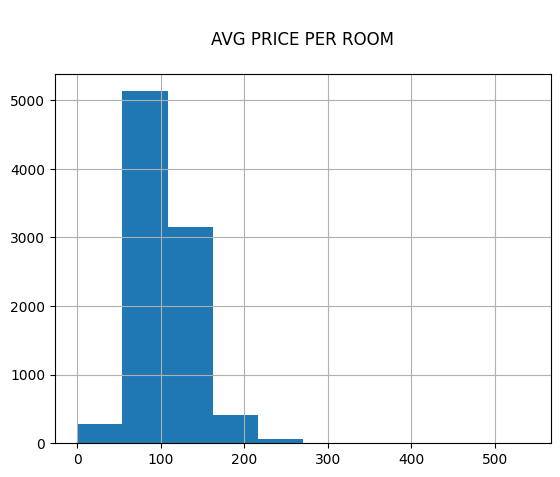

--------------------------------------------------
NO_OF_SPECIAL_REQUESTS
--------------------------------------------------

22.82% is missing


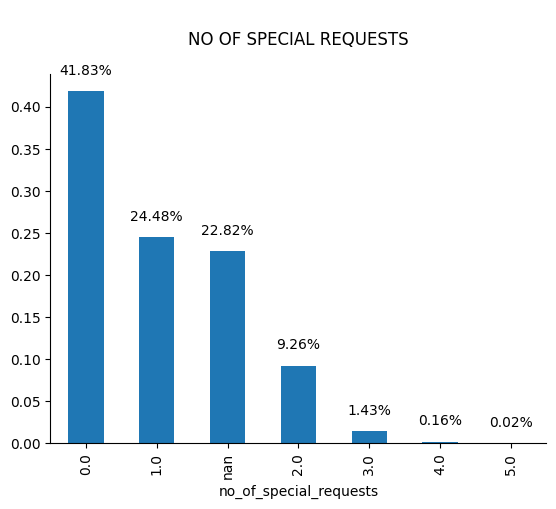

--------------------------------------------------
BOOKING_STATUS
--------------------------------------------------

1.08% is missing


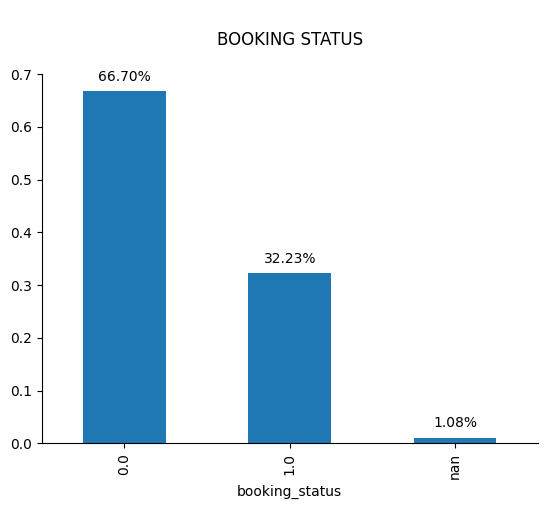

--------------------------------------------------
SAMPLE
--------------------------------------------------

0.00% is missing


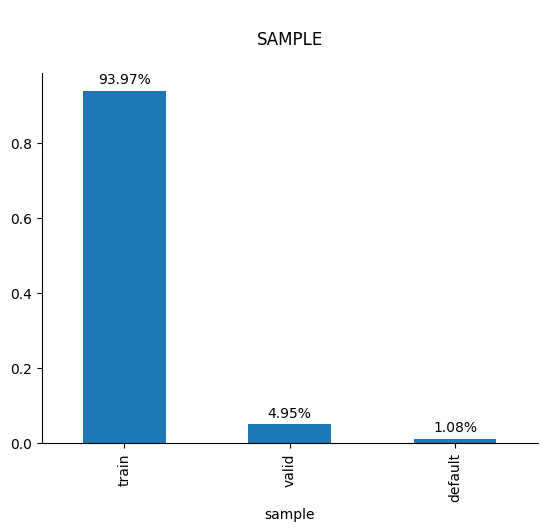

In [19]:
plot_columns(data.columns, data)


# Data preprocessing

As mentioned earlier, our dataset contains categorical variables with more than two levels. In such cases, we need to provide numerical values for XGBoost to process. For this purpose, we have chosen Category encoding, which is described and implemented below.

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot Booking_{category} + \alpha \cdot Booking}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $Booking_{category}$ average booking status in this category and $Booking$ is overall average booking status.

In [20]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_booking = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_booking = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_booking'] + alpha * total_booking) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [21]:
total_booking = np.mean(data[train_mask][col_target])

# encode categorical predictors
# note: the if condition cannot be met, therefore this is there only for the ability to simply change the encoding, with the current setup, the mean_target_encoding will be always used
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
#Our predictors
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

# XGBoost model
XGBoost model is provided in package `xgboost` and we followed reccomandation from https://xgboost.readthedocs.io/en/stable/. #??? Correct?

## Model Fitting

In this part, we first attempted to fit the model manually, using hyperparameters which might work and seeing what would improve the model and what would not. This way we found, that the predictors 'no_of_children' and 'no_of_previous_cancellations' actually make our models worse, so we decidet to omit those. Looking at the AUC of our test subset, we also found that increasing the early stopping rounds to about 25 improved our results as the model were still improving on the test data when the learning stopped with lower values, however going higher than 25 does not generally improve the models further as then sometimes the model actually started getting worse as it overfitted our training data.

Once we learned some basic properties, used grid search with cross validation to find optimal values of our hyperparameters, first, when trying only what seemed like reasonable values, we ended up with our final model since when we let the grid search run over much longer time with wider options, it actually found another solution, however it did not yield better results so we returned to the previous solution.

We should warn that, in order to save time, we manually deleted predictors deemed weak (yes, it's barbaric, but effective nonetheless). So, if one wants to see the graphical reasoning, one should comment out the following two lines below and come back when ready.

In [23]:
#Removing insignificant predictors
cols_pred.remove('no_of_children')
cols_pred.remove('no_of_previous_cancellations')



In [24]:
xgb_model = xgb.XGBClassifier()

In [25]:
# finding optimal parameters using cross validation
#first attempts
param_grid = {
    'max_depth': [6,7,8],
    'eta': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1]
}

In [26]:
#final option when we tried fewer hyperparamteres and changed the options based on results
#leads to 'eta': 0.11, 'gamma': 1.2, 'max_depth': 10, 'tree_method': 'exact', which gave us the best model
param_grid = {
    'max_depth': [9,10,11],
    'eta': [0.12, 0.11, 0.1],
    'gamma': [1.1, 1.2, 1.3],
    'tree_method': ['exact','auto']
}

In [27]:
#We also tried to let the grid search run much longer over many more options
#param_grid = {
#    'max_depth': [4,5,6,7,8,9,10,11,12,13],
#    'eta': [0.03, 0.05, 0.07, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3],
#    'gamma': [0, 0.5, 1, 1.1, 1.2, 1.3, 1.5, 2, 2.5, 3, 3.5, 4],
#    'tree_method': ['exact','auto']
#}
#gives 'eta': 0.12, 'gamma': 1.5, 'max_depth': 10, 'tree_method': 'exact', however the model trained with these parameters yields worse results than the previous

In [34]:
#from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = xgb_model,
                  param_grid = param_grid,
                  scoring = 'roc_auc',
                  cv=5,
                  verbose=4
                 )

In [35]:
#Algortithm that enables us to try different combinations of hyper parametets.
grid_search.fit(data[train_mask][cols_pred], data[train_mask][col_target]) 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=exact;, score=0.823 total time=   0.4s
[CV 2/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=exact;, score=0.815 total time=   0.3s
[CV 3/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=exact;, score=0.823 total time=   0.3s
[CV 4/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=exact;, score=0.814 total time=   0.3s
[CV 5/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=exact;, score=0.819 total time=   0.4s
[CV 1/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=auto;, score=0.821 total time=   0.0s
[CV 2/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=auto;, score=0.811 total time=   0.0s
[CV 3/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=auto;, score=0.819 total time=   0.0s
[CV 4/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=auto;, score=0.813 total time=   0.1s
[CV 5/5] END eta=0.12, gamma=1.1, max_depth=9, tree_method=a

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.12, 0.11, 0.1], 'gamma': [1.1, 1.2, 1.3],
                         'max_depth': [9, 10, 11],
                         'tree_method': ['exact', 'auto']},
             scoring='roc_auc', verbose=4)

In [36]:
#Moreover provides us with the final version
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params


{'eta': 0.11, 'gamma': 1.2, 'max_depth': 10, 'tree_method': 'exact'}

In [37]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': 10,
    'eta': 0.11,
    'gamma': 1.2,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        #(xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)

[0]	train-auc:0.80495	valid-auc:0.78428
[1]	train-auc:0.80723	valid-auc:0.78897
[2]	train-auc:0.80998	valid-auc:0.78863
[3]	train-auc:0.81306	valid-auc:0.79185
[4]	train-auc:0.81887	valid-auc:0.79409
[5]	train-auc:0.82111	valid-auc:0.79463
[6]	train-auc:0.82261	valid-auc:0.79482
[7]	train-auc:0.82367	valid-auc:0.79602
[8]	train-auc:0.82669	valid-auc:0.79691
[9]	train-auc:0.82721	valid-auc:0.79790
[10]	train-auc:0.82934	valid-auc:0.79870
[11]	train-auc:0.83038	valid-auc:0.80058
[12]	train-auc:0.83406	valid-auc:0.80272
[13]	train-auc:0.83647	valid-auc:0.80392
[14]	train-auc:0.83864	valid-auc:0.80456
[15]	train-auc:0.84063	valid-auc:0.80539
[16]	train-auc:0.84335	valid-auc:0.80617
[17]	train-auc:0.84541	valid-auc:0.80724
[18]	train-auc:0.84595	valid-auc:0.80791
[19]	train-auc:0.84685	valid-auc:0.80899
[20]	train-auc:0.84848	valid-auc:0.80984
[21]	train-auc:0.84873	valid-auc:0.81014
[22]	train-auc:0.84941	valid-auc:0.81057
[23]	train-auc:0.84956	valid-auc:0.81087
[24]	train-auc:0.85221	val

## Model evaluation

In the first figure we visualized AUC curve as is #??? we see stopping time and BALBABALA. In second graph we may see plotted importance for predictors. This tool also helped us in deciding, which predictor to remove from the model. 

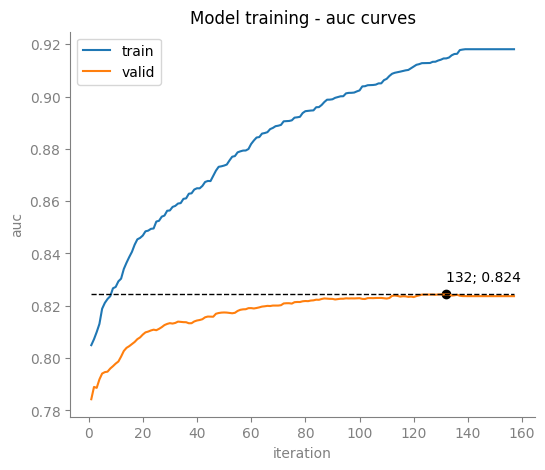

In [38]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1
#best_iteration = 51
ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

In [39]:
#evals_result['test']['auc'][booster.best_iteration+1] #when there is a test subset of the data, this provides the test AUC for the best iteration

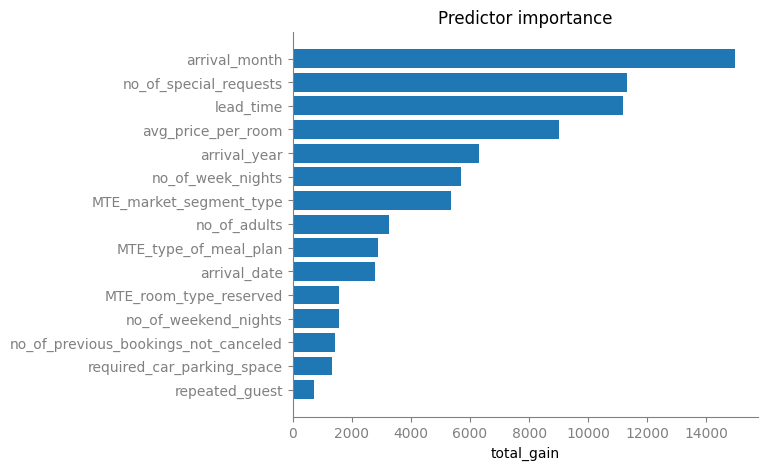

,predictor,strength
0,arrival_month,14981.832031
1,no_of_special_requests,11318.542969
2,lead_time,11163.140625
3,avg_price_per_room,8996.699219
4,arrival_year,6305.419922
5,no_of_week_nights,5700.152344
6,MTE_market_segment_type,5344.826660
7,no_of_adults,3254.540039
8,MTE_type_of_meal_plan,2896.865479
9,arrival_date,2804.264893


In [40]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 15 # Needs to be adjusted
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:15]) # Needs to be adjusted
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:15]) # Needs to be adjusted
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()
predictor_strength

# Prediction

In order to apply our model for the second dataset we need to, once again, make some adjustments to data. Firstly we need to encode the categorical predictors in same manner as in training dataset.

In [41]:
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(test_data[test_data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        test_data['MTE_' + pred] = test_data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
#Colums used for prediction
cols_pred

['no_of_adults',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

In [43]:
#Prediction
dtest = xgb.DMatrix(test_data[cols_pred])
ypred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

## Export

In [44]:
#Exporting data in desired structure
test_data_reset = test_data.reset_index()

# Create a DataFrame with booking IDs and predicted probabilities
predictions_df = pd.DataFrame({
    'Booking_ID': test_data_reset['Booking_ID'],  # Assuming 'Booking_ID' is the name of the index
    'booking_status': ypred
})
predictions_df

,Booking_ID,booking_status
0,INN04969,0.001441
1,INN34541,0.142564
2,INN36109,0.159154
3,INN01554,0.816232
4,INN24975,0.222704
...,...,...
3588,INN29523,0.009470
3589,INN25061,0.445752
3590,INN08475,0.978498
3591,INN13558,0.005679


In [45]:
#In order for the exporting method to work, we isntalled openpyxl library
#pip install openpyxl

In [46]:
from openpyxl import Workbook

In [47]:
# Export DataFrame to Excel
predictions_df.to_excel("predictions12.xlsx", index=False)

print("DataFrame successfully exported to Excel.")

DataFrame successfully exported to Excel.


## Plot individual trees

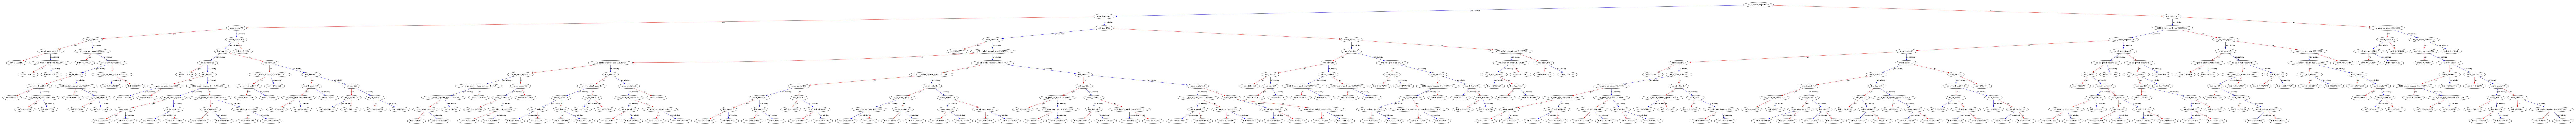

In [48]:
# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 160,100

plot_tree(booster, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

# Conclusion

We uploaded data, encoded cathegorical predictors and also tried to transform some predictors, did not improve model.

First we got an idea, how xgboost works on our data using just ad hoc settings which made sense to us. We learned that including some predictors worsens our model rather then improves it, so we omitted those. During this step we also found what we deemed as optimal train/valid data split for our models.

Then we tried what seemed like reasonable hyperparameter options using grid search to find the best values, which led to our final model.

We also tried to enhance the model further by different transformations of our predictors and similar methods, however we could not find any improvement.